# Solving 2D Ising model on CPU

#### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy as sp

#### Initialize Lattice

In [10]:
N = 50
random = np.random.random((N,N))
lat = np.zeros((N,N))
lat[random >= 0.75 ] = 1
lat[random < 0.75 ] = -1

lat2 = np.zeros((N,N))
lat2[random >= 0.25 ] = 1
lat2[random < 0.25 ] = -1

lat , lat2 , lat.sum() , lat2.sum()

(array([[-1.,  1., -1., ..., -1.,  1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [ 1.,  1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ...,  1., -1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]], shape=(50, 50)),
 array([[ 1.,  1.,  1., ..., -1.,  1., -1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.],
        [ 1.,  1., -1., ...,  1., -1.,  1.],
        ...,
        [-1., -1.,  1., ...,  1.,  1., -1.],
        [ 1.,  1.,  1., ...,  1.,  1., -1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.]], shape=(50, 50)),
 np.float64(-1254.0),
 np.float64(1280.0))

#### Calculate initial Energy(creating a function for that)

Now to get energy we have to arrange the equation in a way $E/J = -\sum_{<i,j>} \sigma_i \sigma_j$

In [11]:
def energy_lat(lattice):
    N, M = lattice.shape
    E = 0
    
    for i in range(N):
        for j in range(M):
            s = lattice[i, j]
            E += s * lattice[(i+1) % N, j]   # right
            E += s * lattice[(i-1) % N, j]   # left
            E += s * lattice[i, (j+1) % M]   # up
            E += s * lattice[i, (j-1) % M]   # down
    
    return E

#### Create a function for metropolis algorithm and run it for one temperature value

In [12]:
@nb.njit("UniTuple (f8[:], 2) (f8[:,:], i8, f8, f8)", nogil=True)

def metropolis_algorithm(lat,step, Beta_x_J, energy):
    lat = lat.copy()
    net_spins = np.zeros(step - 1)
    net_energy = np.zeros(step - 1)
    for t in range(0 , step - 1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = lat[x,y]
        spin_f = spin_i *-1
        E_i = 0
        E_f = 0
        if x > 0 :
            E_i += -spin_i*lat[x-1,y] 
            E_f += -spin_f*lat[x-1,y] 
        if x < N-1 : 
            E_i += -spin_i*lat[x+1,y] 
            E_f += -spin_f*lat[x+1,y]
        if y > 0 :
            E_i += -spin_i*lat[x,y-1] 
            E_f += -spin_f*lat[x,y-1] 
        if y < N-1 : 
            E_i += -spin_i*lat[x,y+1] 
            E_f += -spin_f*lat[x,y+1]

        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-Beta_x_J * dE)):
            lat[x,y] = spin_f
            energy += dE
        elif dE<=0:
            lat[x,y] = spin_f
            energy += dE

        net_spins[t] = lat.sum() 
        net_energy[t]= energy
    
    return net_spins , net_energy

In [28]:
spin , energies = metropolis_algorithm(lat2,1000000, 0.85, energy_lat(lat2))

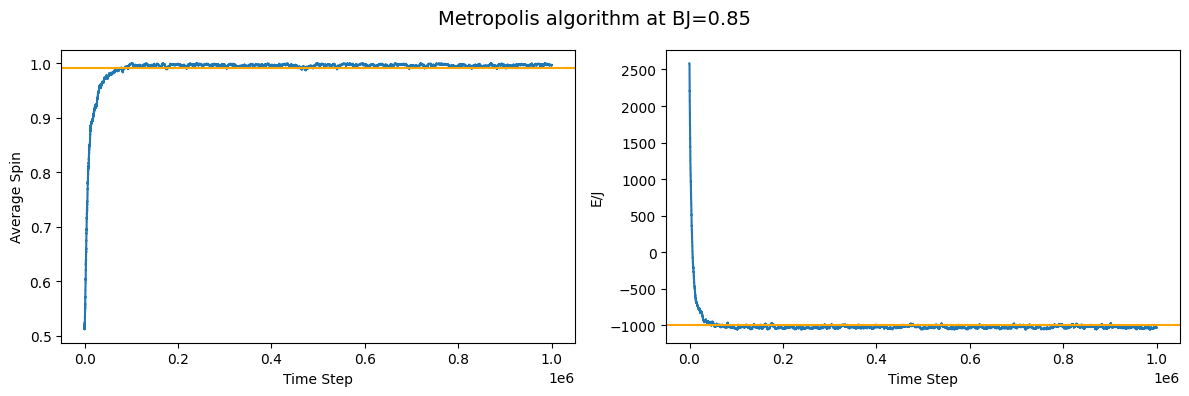

In [29]:
fig , axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]
ax.plot(spin/N**2)
ax.set_ylabel("Average Spin")
ax.set_xlabel("Time Step")
ax.axhline((spin/N**2).mean(), color = 'orange')
ax = axes[1]
ax.plot(energies)
ax.axhline(energies.mean(), color = 'orange')
ax.set_ylabel("E/J")
ax.set_xlabel("Time Step")
fig.suptitle("Metropolis algorithm at BJ=0.85", fontsize=14)
fig.tight_layout()
plt.show()

#### Prepare a function to run ising model on multiple temperatures and get results in spin, mean energy and energy std.

In [32]:
def get_spin_energy_lat(lat, BJs, steps=2000000):
    
    N = lat.shape[0]
    
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))

    for i, BJ in enumerate(BJs):
        spins0 = lat.copy()
        E0 = energy_lat(spins0)
        spins, energies = metropolis_algorithm(spins0, steps, BJ, E0)
        m_eq = spins / (N*N)
        e_eq = energies
        ms[i] = (m_eq[-500000:].mean())
        E_means[i] = e_eq[-500000:].mean()
        E_stds[i] = e_eq[-500000:].std()

    return ms, E_means, E_stds


In [90]:
temp_values = np.arange(0.2,0.8, 0.02)
ns1 , Energies , Energy_std1 = get_spin_energy_lat(lat2,temp_values)

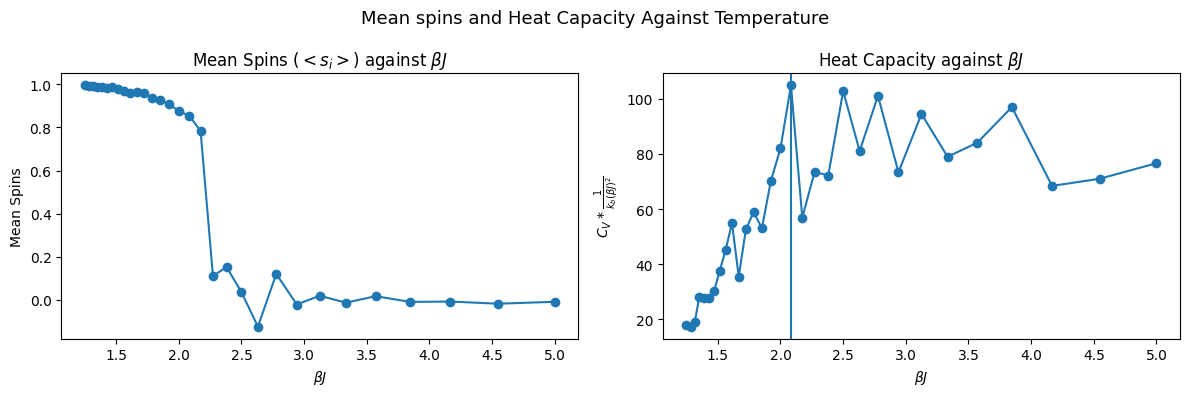

In [93]:
temp_inv = 1/temp_values
peakcv = np.argmax(Energy_std1)
peak_temp = temp_inv[peakcv]
fig , axes = plt.subplots(1,2, figsize = (12,4))
ax = axes[0]
ax.plot(1/temp_values, ns1 , marker = 'o')
ax.set_ylabel("Mean Spins")
ax.set_xlabel(r"$\beta J$")
ax.set_title(r"Mean Spins $(<s_i>)$ against $\beta J$")

ax = axes[1]
ax.plot(1/temp_values, Energy_std1, marker = 'o')
ax.axvline(peak_temp)
ax.set_xlabel(r'$\beta J$')
ax.set_ylabel(r'$C_V * \frac{1}{k_b (\beta J)^2}$')
ax.set_title(r"Heat Capacity against $\beta J$")
fig.suptitle("Mean spins and Heat Capacity Against Temperature", fontsize=13)
fig.tight_layout()
plt.savefig(r"C:\Users\dellg\Desktop\submission\metropolis_plot.png", dpi=300)
plt.show()

In [94]:
print(peak_temp)

2.083333333333334
